In [1]:
import numpy as np
import os


from lmfit.models import GaussianModel,Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture,metrics

# нужно предварительно установить geos
# pip install geos
from shapely.geometry import Polygon  

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

    
from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import ConvexHull
from scipy.spatial import distance
from numpy import linalg 

from skimage import io
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon,subdivide_polygon

from radio_beam.commonbeam import getMinVolEllipse


from grain_utils import grainPreprocess,grainShow,grainMark,grainDraw,grainApprox,grainStats,grainMorphology


In [ ]:
home_path = os.getcwd()
images_folders_path=os.path.join(home_path,'data')

folders_names=os.listdir(images_folders_path)
folders_paths=[os.path.join(images_folders_path,folder) for folder in folders_names]
images_paths_raw=[os.listdir(folder_path) for folder_path in folders_paths]

images_paths=[]
for i,image_line in enumerate(images_paths_raw):
    images_paths.append([])
    for path in image_line:
        images_paths[i].append(os.path.join(folders_paths[i],path))


In [ ]:
c6_2_names=images_paths[3]
#c6_2_images=[grainPreprocess.image_preprocess(Image.open(name),h=150,k=1) for i,name in enumerate(c6_2_names) if i<=20]
#c6_2_images_km=[grainPreprocess.image_preprocess_kmeans(Image.open(name),h=150,k=1) for i,name in enumerate(c6_2_names) if i<=20]

In [6]:
def img_load_preprocess(path,names,h=150,k=1):
    imgs_path=[path+'/'+name for name in names]
    imgs=[]
    for img_path in imgs_path:
        img=io.imread(img_path)
        img=grainPreprocess.image_preprocess(img,h,k)
        imgs.append(img)
    return imgs

In [11]:
path='images'
grain_names=['Ultra_Co8.jpg','Ultra_Co11.jpg','Ultra_Co6_2.jpg','Ultra_Co15.jpg','Ultra_Co25.jpg']
grain_images=img_load_preprocess(path,grain_names)

D:\PROJECTS\python\grain_segmentation\grain_utils.py:59: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img=rgb2gray(gray)


In [ ]:
def angles_approx(origs,images,names,step,N,font_size=20):
    #
    # хорошая аппроксимация 
    #
    for j,image in enumerate(images):
        
        original_angles=grainMark.get_angles(image)
        angles,angles_set,dens_curve=grainStats.stats_preprocess(original_angles,step)
        
        max_val=max(dens_curve)
        x = np.array(angles_set)
        y = np.array(dens_curve)

        norm=np.sum(y)
        
        mus2,sigmas2,amps2=grainApprox.gaussian_fit_bimodal(y,x)
     #   mus3,sigmas3,amps3=grainApprox.gaussian_fit_termodal(y,x,mu1=0,mu2=130,mu3=230,sigma1=1,sigma2=20,sigma3=20)

        x_gauss=range(0,361)
        
        gauss=grainStats.gaussian_bimodal(x_gauss,mus2[0],mus2[1],sigmas2[0],sigmas2[1],amps2[0],amps2[1])
        
      #  gauss=grainStats.gaussian_termodal(x_gauss,mus3[0],mus3[1],mus3[2],
      #                                              sigmas3[0],sigmas3[1],sigmas3[2],
      #                                              amps3[0],amps3[1],amps3[2])
        
        mu1=round(mus2[0],2)
        sigma1=round(sigmas2[0],2)
        amp1=round(amps2[0]/norm,2)
        
        mu2=round(mus2[1],2)
        sigma2=round(sigmas2[1],2)
        amp2=round(amps2[1]/norm,2)
        
    #    mu3=round(mus3[2],2)
    #    sigma3=round(sigmas3[2],2)
    #    amp3=round(amps3[2]/norm,2)
        
        x_gauss1=np.linspace(mu1-sigma1*3,mu1+sigma1*3,100)
        x_gauss2=np.linspace(mu2-sigma2*3,mu2+sigma2*3,100)
     #   x_gauss3=np.linspace(mu3-sigma3*3,mu3+sigma3*3,100)


        
        gauss1=grainStats.gaussian(x_gauss1,mu1,sigma1,amp1)
        gauss2=grainStats.gaussian(x_gauss2,mu2,sigma2,amp2)
      #  gauss3=grainStats.gaussian(x_gauss3,mu3,sigma3,amp3)


     #   plt.legend(text,fontsize=15)
     #   plt.plot(x,y/norm)
     #   plt.hist(angles,bins=100)




        val=round(norm,4)
        total_number='\n количество углов '+str(val)
        text_angle='\n шаг угла '+str(step)+' градусов'
        text=names[j][-20:]+total_number+text_angle
        
        moda1='\n mu1 = '+str(mu1)+' sigma1 = '+str(sigma1)+' amp1 = '+str(amp1)
        moda2='\n mu2 = '+str(mu2)+' sigma2 = '+str(sigma2)+' amp2 = '+str(amp2)
       # moda3='\n mu3 = '+str(mu3)+' sigma3 = '+str(sigma3)+' amp3 = '+str(amp3)
        
        gs = gridspec.GridSpec(2, 2)
        plt.figure(figsize=(N,N))
        
        ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
       # ax1.imshow(grainPreprocess.combine(origs[j],135,1),cmap='gray')
        ax1.set_title('Исходное изображение')

        ax2 = plt.subplot(gs[0, 1]) # row 0, col 1
        ax2.imshow(image,cmap='gray')
        ax2.set_title('Обработанное изображение')

        ax3 = plt.subplot(gs[1, :]) # row 1, span all columns

        ax3.plot(gauss/norm)
        ax3.plot(x_gauss1,gauss1)
        ax3.plot(x_gauss2,gauss2)
       # ax3.plot(x_gauss3,gauss3)
        ax3.scatter(x,y/norm)
     #   ax3.legend([text,moda1,moda2],fontsize=font_size)
        ax3.set_title('распределение углов связующего вещества', fontsize=font_size)
        ax3.set_ylabel('p(x)', fontsize=font_size)
        ax3.set_xlabel('угол связующего вещества, градусы', fontsize=font_size)
        ax3.axvline(x=mu1)
        ax3.axvline(x=mu2)
        ax3.set_ylim([0, max_val/norm])
        ax3.set_xlim([0, 360])

        
       # f,ax=plt.subplots(nrows=2,ncols=2,figsize=(N,N))

       # ax[0,0].imshow(origs[j],cmap='gray')
        
      #  ax[0,1].imshow(image,cmap='gray')
        
      #  ax[1,0].plot(gauss/norm)
      #  ax[1,0].scatter(x,y/norm)
      #  ax[1,0].legend([text],fontsize=font_size)
      #  ax[1,0].set_title('распределение углов связующего вещества', fontsize=font_size)
      #  ax[1,0].set_ylabel('p(x)', fontsize=font_size)
      #  ax[1,0].set_xlabel('угол связующего вещества, градусы', fontsize=font_size)

        plt.savefig('углы_'+names[j][-20:])
        plt.show()

In [ ]:
def angles_approx_metrics(images1,images2,names,step,N,font_size=20):
    #
    # хорошая аппроксимация , сравнение двух методов
    #
    for j,image in enumerate(images1):
        
        original_angles1=grainMark.get_angles(image)
        original_angles2=grainMark.get_angles(images2[j])
        
        angles1,angles_set1,dens_curve1=grainStats.stats_preprocess(original_angles1,step)
        angles2,angles_set2,dens_curve2=grainStats.stats_preprocess(original_angles2,step)
        
        max_val=max(dens_curve1)
        
        x1 = np.array(angles_set1)
        y1 = np.array(dens_curve1)
        norm1=np.sum(y1)
        
        x2 = np.array(angles_set2)
        y2 = np.array(dens_curve2)
        norm2=np.sum(y2)
        
        mus1,sigmas1,amps1=grainApprox.gaussian_fit_bimodal(y1,x1)
        mus2,sigmas2,amps2=grainApprox.gaussian_fit_bimodal(y2,x2,mu1=130,mu2=230)
    

        x_gauss=range(0,361)
        gauss1=grainStats.gaussian_bimodal(x_gauss,mus1[0],mus1[1],sigmas1[0],sigmas1[1],amps1[0],amps1[1])
        gauss2=grainStats.gaussian_bimodal(x_gauss,mus2[0],mus2[1],sigmas2[0],sigmas2[1],amps2[0],amps2[1])
        
        mu11=round(mus1[0],2)
        sigma11=round(sigmas1[0],2)
        amp11=round(amps1[0]/norm1,2)
        
        mu12=round(mus1[1],2)
        sigma12=round(sigmas1[1],2)
        amp12=round(amps1[1]/norm1,2)
        
        
        mu21=round(mus2[0],2)
        sigma21=round(sigmas2[0],2)
        amp21=round(amps2[0]/norm2,2)
        
        mu22=round(mus2[1],2)
        sigma22=round(sigmas2[1],2)
        amp22=round(amps2[1]/norm2,2)


        val1=round(norm1,4)
        total_number1='старый метод\n количество углов '+str(val1)
        
        val2=round(norm2,4)
        total_number2='новый метод(кластеризация)\n количество углов '+str(val2)
        
        loss=(gauss1/norm1-gauss2/norm2)**2
        
        text_angle='\n шаг угла '+str(step)+' градусов'
        text1=names[j][-20:]+total_number1+text_angle
        text2=names[j][-20:]+total_number2+text_angle
        
        moda11='\n mu1 = '+str(mu11)+' sigma1 = '+str(sigma11)+' amp1 = '+str(amp11)
        moda12='\n mu2 = '+str(mu12)+' sigma2 = '+str(sigma12)+' amp2 = '+str(amp12)
        
        moda21='\n mu1 = '+str(mu21)+' sigma1 = '+str(sigma21)+' amp1 = '+str(amp21)
        moda22='\n mu2 = '+str(mu22)+' sigma2 = '+str(sigma22)+' amp2 = '+str(amp22)
        
        gs = gridspec.GridSpec(2, 2)
        plt.figure(figsize=(N,N))
        
        ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
        ax1.imshow(image,cmap='gray')
        ax1.set_title('старый метод',fontsize=15)

        ax2 = plt.subplot(gs[0, 1]) # row 0, col 1
        ax2.imshow(images2[j],cmap='gray')
        ax2.set_title('новый метод',fontsize=15)

        ax3 = plt.subplot(gs[1, :]) # row 1, span all columns

        
        ax3.plot(gauss1/norm1)
        ax3.plot(gauss2/norm2)

        ax3.scatter(x1,y1/norm1)
        ax3.scatter(x2,y2/norm2)
        
        ax3.plot(x_gauss,loss*50)
        
        ax3.legend([total_number1+moda11+moda12+text_angle,
                    total_number2+moda21+moda22+text_angle,
                    'mean squared error loss *50'],
                   fontsize=font_size)
        ax3.set_title('распределение углов связующего вещества', fontsize=font_size)
        ax3.set_ylabel('p(x)', fontsize=font_size)
        ax3.set_xlabel('угол связующего вещества, градусы', fontsize=font_size)
        ax3.set_ylim([0, max_val/norm1])
        ax3.set_xlim([0, 360])
        
       # plt.figure(figsize=(5,5))
        

        plt.savefig('сравнение методов '+names[j][-20:-4])
        plt.show()

In [10]:
def angles_approx(images,names,types,step,N,font_size=20):
    #
    # хорошая аппроксимация , вывод трех распределений
    #
    texts=[]
    gaussians=[]
    scatters_x=[]
    scatters_y=[]
    max_prob=0
    for j,image in enumerate(images):
        
        original_angles=grainMark.get_angles(image)
        angles,angles_set,dens_curve=grainStats.stats_preprocess(original_angles,step)
        
        max_val=max(dens_curve)
        x = np.array(angles_set)
        y = np.array(dens_curve)

        norm=np.sum(y)
        if max_val/norm>max_prob:
            max_prob=max_val/norm
        
        mus2,sigmas2,amps2=grainApprox.gaussian_fit_bimodal(y,x)
   

        x_gauss=range(0,361)
        
        gauss=grainStats.gaussian_bimodal(x_gauss,mus2[0],mus2[1],sigmas2[0],sigmas2[1],amps2[0],amps2[1])
        
        gaussians.append(gauss/norm)
        scatters_x.append(x)
        scatters_y.append(y/norm)
        
        mu1=round(mus2[0],2)
        sigma1=round(sigmas2[0],2)
        amp1=round(amps2[0]/norm,2)
        
        mu2=round(mus2[1],2)
        sigma2=round(sigmas2[1],2)
        amp2=round(amps2[1]/norm,2)
        
        x_gauss1=np.linspace(mu1-sigma1*3,mu1+sigma1*3,100)
        x_gauss2=np.linspace(mu2-sigma2*3,mu2+sigma2*3,100)


        gauss1=grainStats.gaussian(x_gauss1,mu1,sigma1,amp1)
        gauss2=grainStats.gaussian(x_gauss2,mu2,sigma2,amp2)
        
        val=round(norm,4)
        total_number='\n количество углов '+str(val)
        text_angle='\n шаг угла '+str(step)+' градусов'
        
        moda1='\n mu1 = '+str(mu1)+' sigma1 = '+str(sigma1)+' amp1 = '+str(amp1)
        moda2='\n mu2 = '+str(mu2)+' sigma2 = '+str(sigma2)+' amp2 = '+str(amp2)

        text=names[j][-20:]+types[j]+total_number+text_angle+moda1+moda2
        
        texts.append(text)
        
       
    plt.figure(figsize=(4,6))
    plt.rcParams['font.size'] = '20'
    
    plt.plot(gaussians[0])
    plt.plot(gaussians[1])
    plt.plot(gaussians[2])

    plt.scatter(scatters_x[0],scatters_y[0])
    plt.scatter(scatters_x[1],scatters_y[1],marker='v')
    plt.scatter(scatters_x[2],scatters_y[2],marker='s')
    
 #   plt.legend(texts,fontsize=font_size)
    plt.ylabel('p(x)', fontsize=font_size)
    plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)

    plt.ylim([0, max_prob])
#    ax3.set_xlim([0, 360])

    print(texts)


    plt.savefig('распределение углов')
    plt.show()

D:\PROJECTS\python\grain_segmentation\grain_utils.py:429: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours=np.array(contours)


['Ultra_Co8.jpgмелкие зерна\n количество углов 3989\n шаг угла 5 градусов\n mu1 = 114.54 sigma1 = 26.64 amp1 = 3.88\n mu2 = 237.56 sigma2 = 23.98 amp2 = 0.95', 'Ultra_Co11.jpg средние зерна\n количество углов 1937\n шаг угла 5 градусов\n mu1 = 114.36 sigma1 = 30.7 amp1 = 3.58\n mu2 = 228.44 sigma2 = 21.97 amp2 = 1.23', 'Ultra_Co6_2.jpg крупные зерна\n количество углов 1225\n шаг угла 5 градусов\n mu1 = 111.16 sigma1 = 33.99 amp1 = 3.26\n mu2 = 235.81 sigma2 = 27.44 amp2 = 1.49']


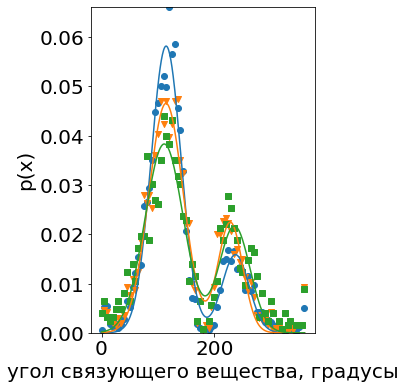

In [13]:
N=10

#images=[image1,image2,image3,image4,image5]
#origs=[grain1_pil,grain2_pil,grain3_pil,grain4_pil,grain5_pil]
#images=[image1km]
#images_true=[image1 ]
step=5
#names=[grain1_name,grain2_name,grain3_name,grain4_name,grain5_name]
#names=['сплав с крупными зернами']
#p=10
#angles_approx(c6_2_images[:p],c6_2_images[:p],c6_2_names[:p],step,N)
#angles_approx(images,images_true,names,step,N)
#angles_approx_metrics(c6_2_images,c6_2_images_km,c6_2_names,step,N)


images=grain_images[:3]
names=grain_names[:3]
types=['мелкие зерна',' средние зерна',' крупные зерна']
angles_approx(images,names,types,step,N)

## Распределение диаметров

https://radio-beam.readthedocs.io/en/latest/api/radio_beam.commonbeam.getMinVolEllipse.html#radio_beam.commonbeam.getMinVolEllipse

In [ ]:
def diametr_approx(origins,images,names,step,val1,val2,pixel,N):
    text=[]
    bins=150
    
    for j,image in enumerate(images):

        a_beams,b_beams,angles,cetroids=grainMark.get_mvee_params(image,0.2)
        
        distances1,dist1_set,dens1_curve=grainStats.stats_preprocess(a_beams,step)
        distances2,dist2_set,dens2_curve=grainStats.stats_preprocess(b_beams,step)
        angles,angles_set,angles_dens_curve=grainStats.stats_preprocess(np.rad2deg(angles).astype('int32'),step=5)

        
        x1 = np.array([dist1_set]).reshape(-1, 1)*pixel
        y1 = np.array([dens1_curve]).reshape(-1, 1)
        
        x2 = np.array([dist2_set]).reshape(-1, 1)*pixel
        y2 = np.array([dens2_curve]).reshape(-1, 1)
        
        xy1=np.concatenate([x1, y1],axis=1)
        xy2=np.concatenate([x2, y2],axis=1)
        
        new_xy1=[]
        new_xy2=[]
        # косяк при нормировке
        norm1=round(np.sum(dens1_curve),6)
        norm2=round(np.sum(dens2_curve),6)
        
        angle_norm=np.sum(angles_dens_curve)
        
        
        for line in xy1:
            if line[0]>val1 and np.log(line[1])>val2*norm1 :
                new_xy1.append(line.copy())

        for line in xy2:
            if line[0]>val1 and np.log(line[1])>val2*norm2 :
                new_xy2.append(line.copy())
        
        new_xy1=np.array(new_xy1)
        new_xy2=np.array(new_xy2)
        
        x1=new_xy1[:,0].reshape(-1, 1)
        y1=new_xy1[:,1].reshape(-1, 1)
        x2=new_xy2[:,0].reshape(-1, 1)
        y2=new_xy2[:,1].reshape(-1, 1)
        
        y1=y1/norm1
        y2=y2/norm2
        
        x_linear1=np.linspace(x1.min(axis=0),x1.max(axis=0),50).reshape(-1, 1)
        x_linear2=np.linspace(x2.min(axis=0),x2.max(axis=0),50).reshape(-1, 1)
        
        reg1 = LinearRegression().fit(x1,y1)
        reg2 = LinearRegression().fit(x2,y2)
        
        lin_predict1=reg1.predict(x_linear1)
        lin_predict2=reg2.predict(x_linear2)
        
        
        k1=reg1.coef_[0][0]
        k2=reg2.coef_[0][0]
        
        angle1=round(np.rad2deg(np.arctan(k1)),4)
        angle2=round(np.rad2deg(np.arctan(k2)),4)
        
        score1=round(reg1.score(x1, y1),2)
        score2=round(reg2.score(x2, y2),2)
        
        val=pixel*step
            
        num1='\n количество регионов связ. в-ва  '+str(norm1)
        lin_k1='\n угол наклона '+str(angle1)+' градусов'
        acc1='\n точность '+str(score1)
        text_step1='\n шаг длины диаметра '+str(val)+'$ мкм$'
        text1=names[j]+lin_k1+acc1+num1+text_step1
        

        num2='\n количество регионов связ. в-ва '+str(norm1)
        lin_k2='\n угол наклона '+str(angle2)+' градусов'
        acc2='\n точность '+str(score2)
        text_step2='\n шаг длины диаметра '+str(val)+'$ мкм$'
        text2=names[j]+lin_k2+acc2+num2+text_step2
        

        gs = gridspec.GridSpec(2, 2)
        plt.figure(figsize=(6,8))
        
        ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
        ax1.imshow(grainPreprocess.combine(origs[j],135,1),cmap='gray')
        ax1.set_title('Исходное изображение')

        ax2 = plt.subplot(gs[0, 1]) # row 0, col 1
        ax2.plot(angles_set,angles_dens_curve/angle_norm)
        ax2.set_title('Распределение углов наклона эллипса',fontsize=15)
        ax2.set_ylabel('p(x)', fontsize=20)
        ax2.set_xlabel('угол наклона, градусы', fontsize=20)

        ax3 = plt.subplot(gs[1, 0]) # row 1, span all columns
        ax3.plot(x_linear1,lin_predict1)

        ax3.scatter(x1,y1)
        ax3.legend([text1],fontsize=12,loc=1)
        ax3.set_title('распределение a-полуосей связующего вещества', fontsize=15)
        ax3.set_ylabel('ln(p(x))', fontsize=20)
        ax3.set_xlabel('длина полуоси, мкм', fontsize=20)
        
        ax4 = plt.subplot(gs[1, 1]) # row 1, span all columns
        ax4.plot(x_linear2,lin_predict2)

        ax4.scatter(x2,y2)
        
        ax4.legend([text2],fontsize=12)
        ax4.set_title('распределение b-полуосей связующего вещества', fontsize=15)
        ax4.set_ylabel('ln(p(x))', fontsize=20)
        ax4.set_xlabel('длина полуоси, мкм', fontsize=20)

        
      #  plt.savefig('диаметры_'+names[j])
        plt.show()

        
    


In [14]:
def diametr_approx(origins,images,names,types,step,pixel,N,M):
    texts1=[]
    texts2=[]
    
    x_val1=[]
    y_val1=[]
    
    x_val2=[]
    y_val2=[]
    
    x_predict1=[]
    y_predict1=[]
    
    x_predict2=[]
    y_predict2=[]
    
    for j,image in enumerate(images):

        a_beams,b_beams,angles,cetroids=grainMark.get_mvee_params(image,0.2)
        
        distances1,dist1_set,dens1_curve=grainStats.stats_preprocess(a_beams,step)
        distances2,dist2_set,dens2_curve=grainStats.stats_preprocess(b_beams,step)
        angles,angles_set,angles_dens_curve=grainStats.stats_preprocess(np.rad2deg(angles).astype('int32'),step=5)

        norm1=round(np.sum(dens1_curve),6)
        norm2=round(np.sum(dens2_curve),6)
        
        
        x1 = np.array([dist1_set]).reshape(-1, 1)*pixel
        y1 = np.log([dens1_curve/norm1]).reshape(-1, 1)
        
        x2 = np.array([dist2_set]).reshape(-1, 1)*pixel
        y2 = np.log([dens2_curve/norm2]).reshape(-1, 1)
        

        
        x1=x1[2:-3]
        y1=y1[2:-3]
        
        x2=x2[2:-3]
        y2=y2[2:-3]
        
        xy1=np.concatenate([x1, y1],axis=1)
        xy2=np.concatenate([x2, y2],axis=1)
    
        x1=xy1[:,0].reshape(-1, 1)
        y1=xy1[:,1].reshape(-1, 1)
        x2=xy2[:,0].reshape(-1, 1)
        y2=xy2[:,1].reshape(-1, 1)
        

        
        x_linear1=np.linspace(x1.min(axis=0),x1.max(axis=0),50).reshape(-1, 1)
        x_linear2=np.linspace(x2.min(axis=0),x2.max(axis=0),50).reshape(-1, 1)
        
        reg1 = LinearRegression().fit(x1,y1)
        reg2 = LinearRegression().fit(x2,y2)
        
        lin_predict1=reg1.predict(x_linear1)
        lin_predict2=reg2.predict(x_linear2)
        
        
        k1=reg1.coef_[0][0]
        k2=reg2.coef_[0][0]
        
        b1=reg1.predict([[0]])[0][0]
        b2=reg2.predict([[0]])[0][0]
        
        
        angle1=round(np.rad2deg(np.arctan(k1)),4)
        angle2=round(np.rad2deg(np.arctan(k2)),4)
        
        score1=round(reg1.score(x1, y1),2)
        score2=round(reg2.score(x2, y2),2)
        
        val=pixel*step
            
        num1='\n количество регионов связ. в-ва  '+str(norm1)
        lin_k1='\n коэффициент k '+str(round((k1),3))
        lin_k1_angle='\n угол наклона '+str(angle1)+' градусов, сдвиг b '+str(round(b1,4))
        acc1='\n точность '+str(score1)
        text_step1='\n шаг длины диаметра '+str(val)+'$ мкм$'
        mean_text1='\nсреднее значение длины '+str(round(distances1.mean()*pixel,4))
        text1=names[j]+types[j]+lin_k1+ lin_k1_angle+acc1+num1+text_step1+mean_text1
    #    text1=names[j]+types[j]
        

        num2='\n количество регионов связ. в-ва '+str(norm1)
        lin_k2='\n коэффициент k '+str(round((k2),3))
        lin_k2_angle='\n угол наклона '+str(angle2)+' градусов'+' градусов, сдвиг b '+str(round(b2,4))
        acc2='\n точность '+str(score2)
        text_step2='\n шаг длины диаметра '+str(val)+'$ мкм$'
        mean_text2='\nсреднее значение длины '+str(round(distances2.mean()*pixel,4))
        text2=names[j]+types[j]+lin_k2+lin_k2_angle+acc2+num2+text_step2+mean_text2
      #  text2=names[j]+types[j]
        
        texts1.append(text1)
        texts2.append(text2)
        
        x_val1.append(x1)
        y_val1.append(y1)
        
        x_val2.append(x2)
        y_val2.append(y2)
        
        x_predict1.append(x_linear1)
        y_predict1.append(lin_predict1)
        
        x_predict2.append(x_linear2)
        y_predict2.append(lin_predict2)
        
    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(2, 1)
    # для статьи 12,18
    plt.figure(figsize=(N,M))

    ax3 = plt.subplot(gs[0]) # row 1, span all columns
    
  #  ax3.grid()
    ax3.plot(x_predict1[0],y_predict1[0])
    ax3.plot(x_predict1[1],y_predict1[1])
    ax3.plot(x_predict1[2],y_predict1[2])
    
    ax3.scatter(x_val1[0],y_val1[0])
    ax3.scatter(x_val1[1],y_val1[1],marker='v')
    ax3.scatter(x_val1[2],y_val1[2],marker='s')
    
  #  ax3.legend(texts1,fontsize=14,loc=1)
   # ax3.set_title('распределение a-полуосей связующего вещества', fontsize=15)
    ax3.set_ylabel('ln(p(x))', fontsize=15)
    ax3.set_xlabel('длина полуоси, мкм', fontsize=15)

    ax4 = plt.subplot(gs[1]) # row 1, span all columns
    
  #  ax4.grid()
    ax4.plot(x_predict2[0],y_predict2[0])
    ax4.plot(x_predict2[1],y_predict2[1])
    ax4.plot(x_predict2[2],y_predict2[2])
    
    ax4.scatter(x_val2[0],y_val2[0])
    ax4.scatter(x_val2[1],y_val2[1],marker='v')
    ax4.scatter(x_val2[2],y_val2[2],marker='s')
    
#    ax4.legend(texts2,fontsize=14,loc=1)
  #  ax4.set_title('распределение b-полуосей связующего вещества', fontsize=15)
    ax4.set_ylabel('ln(p(x))', fontsize=15)
    ax4.set_xlabel('длина полуоси, мкм', fontsize=15)
    print(texts1)
    print(texts2)


  #  plt.savefig('распределение полуосей')
    plt.show()

        

In [ ]:
N=6
M=8
# для статье N=12,M=18
pixel=49.7/1000
images=[image1,image2,image3,image4,image5]
origs=[grain1_pil,grain2_pil,grain3_pil,grain4_pil,grain5_pil]
#images=[image2]
step=5

names=[grain1_name,grain2_name,grain3_name,grain4_name,grain5_name]
#names=['сплав с крупными зернами']

images=[image2,image3,image1]
names=[grain2_name,grain3_name,grain1_name]
types=[' мелкие зерна',' средние зерна',' крупные зерна']

#diametr_approx(origs,images,names,step,val1,val2,pixel,N)


images=grain_images[:3]
names=grain_names[:3]
types=['мелкие зерна',' средние зерна',' крупные зерна']

diametr_approx(origs,images,names,types,step,pixel,N,M)

In [ ]:
image=image2
#grainShow.enclosing_ellipse_show(image,14,N=10)

## Распределение дуг

In [15]:
from shapely.ops import triangulate # для установки shapely надо использовать conda install -c conda-forge shapely
from shapely.geometry import MultiPoint,Point,Polygon

In [16]:
def get_inner_side(polygon,triangles):
    l_polygon=polygon.shape[0]

    sides=[]
    for triangle in triangles:
        l_triangle=triangle.shape[0]
        for i,t_point1 in enumerate(triangle[:l_triangle-1]):
            t_point2=triangle[i+1]
            for j,p_point1 in enumerate(polygon):
                if j==0 or j==l_polygon-1:
                    p_point2=polygon[-2]
                    p_point3=polygon[1]
                else:
                    p_point2=polygon[j-1]
                    p_point3=polygon[j+1]

                cond11= all([t_point1[0]==p_point1[0],
                           t_point1[1]==p_point1[1]])

                cond22= all([t_point2[0]==p_point2[0],
                           t_point2[1]==p_point2[1]])

                cond23= all([t_point2[0]==p_point3[0],
                           t_point2[1]==p_point3[1]])

                if cond11 and not (cond22 or cond23):
                    sides.append([t_point1,t_point2])
 

    for i,side1 in enumerate(sides):
        for j,side2 in enumerate(sides):
            cond1=all([side1[0][0]==side2[0][0],
                      side1[0][1]==side2[0][1]])
            
            cond2=all([side1[1][0]==side2[1][0],
                      side1[1][1]==side2[1][1]])
            if cond1 and cond2:
                sides.pop(j)
    
    return np.array(sides)


In [17]:
def get_median_points(polygon,sides):
    points=[]
    for i,side in enumerate(sides):
        x=(side[0][0]+side[1][0])/2
        y=(side[0][1]+side[1][1])/2
        point=Point(x,y)
        if point.within(polygon) and x and y:
            points.append((x,y))
    return np.array(points)

## Неиспользуемый код

In [19]:
## создание линии скелета
image1=grain_images[0]
cnt=grainMark.get_contours(image1)
img=grainDraw.draw_edges(image1,cnt)
#io.imsave('cnt_no_grad.png',img)

D:\PROJECTS\python\grain_segmentation\grain_utils.py:429: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours=np.array(contours)


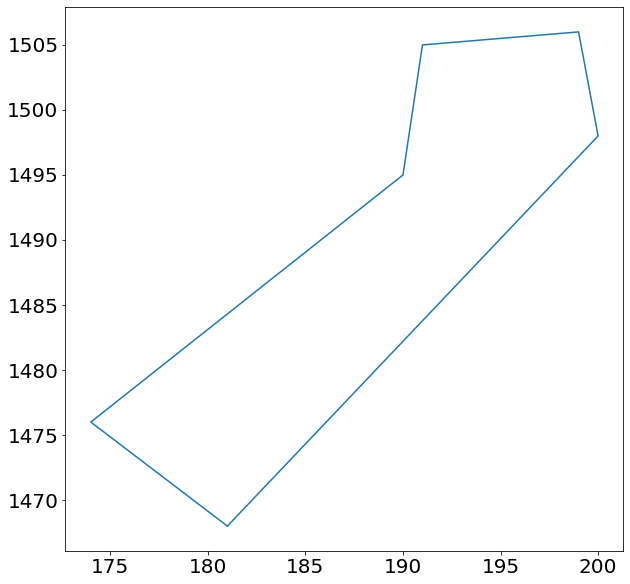

In [25]:
i=27
#27 супер кривой
M=10
data=cnt[i]
data[-1]=data[0]
polygon=np.array(data)

points = MultiPoint(data)
triangles = triangulate(points)
triang=[]
for triangle in triangles:
    triang.append(list(triangle.exterior.coords))
triang=np.array(triang)

sides=get_inner_side(polygon,triang)
poly=Polygon(data)
points=get_median_points(poly,sides)
plt.figure(figsize=(M,M))

#plt.scatter(points[:,0],points[:,1])


plt.plot(polygon[:,0],polygon[:,1])
plt.show()

In [ ]:

plt.plot(triang[0,:,0],triang[0,:,1])
plt.plot(triang[1,:,0],triang[1,:,1])
plt.plot(triang[2,:,0],triang[2,:,1])
#plt.plot(triang[3,:,0],triang[3,:,1])
#plt.plot(triang[4,:,0],triang[4,:,1])
plt.show()

In [ ]:
plt.plot()

In [ ]:
def triangulate_within(polygon):
    return [triangle for triangle in triangulate(polygon) if triangle.within(polygon)]

In [ ]:
new_triang=triangulate_within(points)